In [1]:
import pennylane as qml

### Encoding Method

In [2]:
j=2
eps=3
g=2
V=1
v=12

In [3]:
# Encode indices with the specified rule
def encode_indices(p, m, j):
    if p not in {1, -1}:
        raise ValueError("p must be either 1 or -1.")
    if m == 0 or not (-j <= m <= j):
        raise ValueError(f"m must be in the range +/-1, +/-2, ..., +/-j, but got m={m} and j={j}.")

    if m > 0:
        k = j - m
    else:
        k = j - m - 1 # shift by one because m can't be 0

    if p == -1:
        k += 2 * j

    return k

# Decode a single index back into multi-indices (p, m, j)
def decode_index(k, j):
    if k < 0 or k >= 4 * j:
        raise ValueError(f"k={k} is out of valid range for j={j}.")

    # Determine p based on the range of k
    p = 1 if k < 2 * j else -1

    # Adjust k for p = -1
    k_adjusted = k if p == 1 else k - 2 * j

    # Determine m
    m = j - k_adjusted if k_adjusted < j else j - (k_adjusted + 1) # inverse of the encoding line in encode_indices

    return p, m

### Test Encoding

In [4]:

for p in [1, -1]:
    for m in range(j, -j-1, -1):
        if m == 0: continue

        k = encode_indices(p, m, j)
        p_, m_ = decode_index(k, j)

        print("Original indices: p={}, m={}".format(p, m, j))
        print("Decoded indices:  p={}, m={}".format(p_, m_))
        print("Encoded index:    k={}".format(k))
        print()

Original indices: p=1, m=2
Decoded indices:  p=1, m=2
Encoded index:    k=0

Original indices: p=1, m=1
Decoded indices:  p=1, m=1
Encoded index:    k=1

Original indices: p=1, m=-1
Decoded indices:  p=1, m=-1
Encoded index:    k=2

Original indices: p=1, m=-2
Decoded indices:  p=1, m=-2
Encoded index:    k=3

Original indices: p=-1, m=2
Decoded indices:  p=-1, m=2
Encoded index:    k=4

Original indices: p=-1, m=1
Decoded indices:  p=-1, m=1
Encoded index:    k=5

Original indices: p=-1, m=-1
Decoded indices:  p=-1, m=-1
Encoded index:    k=6

Original indices: p=-1, m=-2
Decoded indices:  p=-1, m=-2
Encoded index:    k=7



### Hamiltonian

In [5]:
# Annihilation operator
def C(p, m, j):
    return qml.FermiA(encode_indices(p, m, j))

# Creation operator
def C_dag(p, m, j):
    return qml.FermiC(encode_indices(p, m, j))

# Agassi Hamiltonian
def agassi_hamiltonian(j, eps, g, V):
    
    # J0 term
    J0 = 0
    for m in range(j, -j-1, -1):
        if m == 0: continue
        J0 += C_dag(1, m, j) * C(1, m, j) - C_dag(-1, m, j) * C(-1, m, j)
    J0 *= 0.5

    # J+ and J- term
    J_plus = 0
    J_minus = 0
    for m in range(j, -j-1, -1):
        if m == 0: continue
        J_plus  += C_dag(1, m, j) * C(-1, m, j)
        J_minus += C_dag(-1, m, j) * C(1, m, j)

    # A_i terms
    
    def A_dag(p, j):
        res = 0
        # unlike the previous loops here we go from m=0 to m=j-1 (m=1 to m=j in the paper)
        for m in range(0, j+1):
            if m == 0: continue
            res += C_dag(p, m, j) * C_dag(p, -m, j)
        return res
    
    def A(p, j):
        res = 0
        # unlike the previous loops here we go from m=0 to m=j-1 (m=1 to m=j in the paper)
        for m in range(0, j+1):
            if m == 0: continue
            res += C(p, -m, j) * C(p, m, j)
        return res

    A_terms = 0
    for p in [-1, 1]:
        for p_ in [-1, 1]:
            A_terms += A_dag(p, j) * A(p_, j)
    
    
    # Hamiltonian
    H = eps * J0 - g * A_terms - V/2 * (J_plus * J_plus + J_minus * J_minus)
    
    return H

H_sec = agassi_hamiltonian(j, eps, g, V)
print("Second quantization Hamiltonian:")
print(H_sec)
print()

H_ps = qml.jordan_wigner(H_sec, ps=True)
# H = H.simplify()
print("Jordan-Wigner Hamiltonian:")
print(H_ps)
print()


Second quantization Hamiltonian:
-0.5 * a⁺(0) a(4) a⁺(0) a(4)
+ -0.0 * a⁺(0) a(4)
+ -0.5 * a⁺(0) a(4) a⁺(1) a(5)
+ -0.5 * a⁺(0) a(4) a⁺(2) a(6)
+ -0.5 * a⁺(0) a(4) a⁺(3) a(7)
+ 0.0 * I
+ -0.0 * a⁺(1) a(5)
+ -0.0 * a⁺(2) a(6)
+ -0.0 * a⁺(3) a(7)
+ -0.5 * a⁺(1) a(5) a⁺(0) a(4)
+ -0.5 * a⁺(1) a(5) a⁺(1) a(5)
+ -0.5 * a⁺(1) a(5) a⁺(2) a(6)
+ -0.5 * a⁺(1) a(5) a⁺(3) a(7)
+ -0.5 * a⁺(2) a(6) a⁺(0) a(4)
+ -0.5 * a⁺(2) a(6) a⁺(1) a(5)
+ -0.5 * a⁺(2) a(6) a⁺(2) a(6)
+ -0.5 * a⁺(2) a(6) a⁺(3) a(7)
+ -0.5 * a⁺(3) a(7) a⁺(0) a(4)
+ -0.5 * a⁺(3) a(7) a⁺(1) a(5)
+ -0.5 * a⁺(3) a(7) a⁺(2) a(6)
+ -0.5 * a⁺(3) a(7) a⁺(3) a(7)
+ -0.5 * a⁺(4) a(0) a⁺(4) a(0)
+ -0.0 * a⁺(4) a(0)
+ -0.5 * a⁺(4) a(0) a⁺(5) a(1)
+ -0.5 * a⁺(4) a(0) a⁺(6) a(2)
+ -0.5 * a⁺(4) a(0) a⁺(7) a(3)
+ -0.0 * a⁺(5) a(1)
+ -0.0 * a⁺(6) a(2)
+ -0.0 * a⁺(7) a(3)
+ -0.5 * a⁺(5) a(1) a⁺(4) a(0)
+ -0.5 * a⁺(5) a(1) a⁺(5) a(1)
+ -0.5 * a⁺(5) a(1) a⁺(6) a(2)
+ -0.5 * a⁺(5) a(1) a⁺(7) a(3)
+ -0.5 * a⁺(6) a(2) a⁺(4) a(0)
+ -0.5 * a⁺(6) a(2) a⁺(5

In [6]:


# Agassi Hamiltonian paired
def agassi_hamiltonian1(j, eps, g, V):
    
    # J0 term
    J0 = 0
    for m in range(j, -j-1, -1):
        if m == 0: continue
        J0 += C_dag(1, m, j) * C(1, m, j) - C_dag(-1, m, j) * C(-1, m, j)
    J0 *= 0.5

    # J+ and J- term
    J_plus = 0
    J_minus = 0
    for m in range(j, -j-1, -1):
        if m == 0: continue
        J_plus  += C_dag(1, m, j) * C(-1, m, j)
        J_minus += C_dag(-1, m, j) * C(1, m, j)

    # A_i terms
    
    def A_dag(p, j):
        res = 0
        # unlike the previous loops here we go from m=0 to m=j-1 (m=1 to m=j in the paper)
        for m in range(0, j+1):
            if m == 0: continue
            res += C_dag(p, m, j) * C_dag(p, -m, j)
        return res
    
    def A(p, j):
        res = 0
        # unlike the previous loops here we go from m=0 to m=j-1 (m=1 to m=j in the paper)
        for m in range(0, j+1):
            if m == 0: continue
            res += C(p, -m, j) * C(p, m, j)
        return res

    
    
    A_terms_Paired = 0
    for p in [-1, 1]:
        A_terms_Paired += A_dag(p, j) * A(p, j)

    A_terms_Unpaired = 0
    for p in [-1, 1]:
        A_terms_Unpaired += A_dag(p, j) * A(-p, j)

    # Hamiltonian
    H_1 = eps * J0 - g * A_terms_Paired
    H_2 = - g * A_terms_Unpaired - V/2 * (J_plus * J_plus + J_minus * J_minus) 
    

    H_ps1 = qml.jordan_wigner(H_1, ps=True)
    H_ps2 = qml.jordan_wigner(H_2, ps=True)

    return H_ps1, H_ps2


In [7]:
def test_commutativity(H_1, H_2):
    from pennylane.pauli import PauliSentence
    from itertools import combinations
    from pennylane import numpy as np

    split_sentences1 = {}

    for pauli_word, value in H_1.items():
        # If this number is not already in the dictionary, initialize a new PauliSentence
        if pauli_word not in split_sentences1:
            split_sentences1[pauli_word] = PauliSentence()

    # Iterate over all pairs of PauliSentences from split_sentences1 and test commutativity
    for (key1, ps1), (key2, ps2) in combinations(split_sentences1.items(), 2):
        # Compute their commutator
        comm = qml.commutator(key1,key2, pauli=True)
        # Check if they commute
        if np.allclose(comm.operation().matrix(), np.zeros_like(comm.operation().matrix())):
            print(f"{key1} and {key2} commute.")
        else:
            print(f"{key1} and {key2} do NOT commute.")

    split_sentences2 = {}

    for pauli_word, value in H_2.items():
        # If this number is not already in the dictionary, initialize a new PauliSentence
        if pauli_word not in split_sentences2:
            split_sentences2[pauli_word] = PauliSentence()

    # Iterate over all pairs of PauliSentences from split_sentences2 and test commutativity
    for (key1, ps1), (key2, ps2) in combinations(split_sentences2.items(), 2):
        # Compute their commutator
        comm = qml.commutator(key1,key2, pauli=True)
        

        # Check if they commute
        if np.allclose(comm.operation().matrix(), 0):
            print(f"{key1} and {key2} commute.")
        else:
            print(f"{key1} and {key2} do NOT commute.")

In [8]:
H_1, H_2 = agassi_hamiltonian1(j, eps, g, V)
test_commutativity(H_1, H_2)

I and Z(5) commute.
I and Z(6) commute.
I and Z(5) @ Z(6) commute.
I and Y(4) @ X(5) @ Y(6) @ X(7) commute.
I and X(4) @ X(5) @ Y(6) @ Y(7) commute.
I and X(4) @ X(5) @ X(6) @ X(7) commute.
I and Y(4) @ X(5) @ X(6) @ Y(7) commute.
I and X(4) @ Y(5) @ Y(6) @ X(7) commute.
I and Y(4) @ Y(5) @ Y(6) @ Y(7) commute.
I and Y(4) @ Y(5) @ X(6) @ X(7) commute.
I and X(4) @ Y(5) @ X(6) @ Y(7) commute.
I and Z(4) commute.
I and Z(7) commute.
I and Z(4) @ Z(7) commute.
I and Z(1) commute.
I and Z(2) commute.
I and Z(1) @ Z(2) commute.
I and Y(0) @ X(1) @ Y(2) @ X(3) commute.
I and X(0) @ X(1) @ Y(2) @ Y(3) commute.
I and X(0) @ X(1) @ X(2) @ X(3) commute.
I and Y(0) @ X(1) @ X(2) @ Y(3) commute.
I and X(0) @ Y(1) @ Y(2) @ X(3) commute.
I and Y(0) @ Y(1) @ Y(2) @ Y(3) commute.
I and Y(0) @ Y(1) @ X(2) @ X(3) commute.
I and X(0) @ Y(1) @ X(2) @ Y(3) commute.
I and Z(0) commute.
I and Z(3) commute.
I and Z(0) @ Z(3) commute.
Z(5) and Z(6) commute.
Z(5) and Z(5) @ Z(6) commute.
Z(5) and Y(4) @ X(5) @ 

### Split Hamiltonian

In [9]:
# def split_pauli_sentence_by_operators(ps):
#     """
#     Splits a Pauli sentence into different Pauli sentences, each composed of 
#     Pauli words with the same number of operators.

#     Args:
#         ps (PauliSentence): The input Pauli sentence.

#     Returns:
#         dict: A dictionary where the keys are the number of operators, and 
#               the values are Pauli sentences containing words with that number of operators.
#     """

#     # Dictionary to store split Pauli sentences
#     split_sentences = {}

#     for pauli_word, coefficient in ps.items():
#         # Determine the number of operators in the PauliWord
#         num_operators = len(pauli_word)

#         # If this number is not already in the dictionary, initialize a new PauliSentence
#         if num_operators not in split_sentences:
#             split_sentences[num_operators] = qml.pauli.PauliSentence()

#         # Add the current PauliWord to the corresponding PauliSentence
#         split_sentences[num_operators][pauli_word] = coefficient

#     return split_sentences

In [10]:
# # Split the PauliSentence
# split_result = split_pauli_sentence_by_operators(H_ps)

# # Display the result
# for num_ops, sentence in split_result.items():
#     print(f"Pauli words with {num_ops} operators:")
#     print(sentence)
#     print()

In [11]:
# len(split_result)

### Add Implicit Terms to Hamiltonian

In [12]:
from copy import deepcopy

def add_implicit_terms(H1_raw, n):
    H_new = deepcopy(H1_raw)
    for i in range(0, n):
        w = qml.pauli.PauliWord({i:"Z"})
        if w not in H1_raw:
            H_new[w] = 0.0
    return H_new



In [13]:
n_qubits = 4*j
def get_ham_terms1(n_qubits):
    # get the different hamiltonian terms
    H_1full = add_implicit_terms(H_1, n_qubits).operation().matrix()
    H_2full = add_implicit_terms(H_2, n_qubits).operation().matrix()
    return H_1full, H_2full

In [14]:
# def get_ham_terms(n_qubits):
#     # get the different hamiltonian terms
#     H1_raw = split_result[1]
#     H1 = add_implicit_terms(H1_raw, n_qubits).operation().matrix()
#     H2 = split_result[2].operation().matrix()
#     H3 = split_result[4].operation().matrix()
#     return H1, H2, H3

### Automatically Calculate Commutators

In [15]:

# from itertools import combinations
# from pennylane.pauli import PauliSentence

# # Iterate over all pairs of PauliSentences from split_result and test commutativity
# for (num_ops1, ps1), (num_ops2, ps2) in combinations(split_result.items(), 2):
#     # Compute their commutator
#     comm = ps1.commutator(ps2)

#     # Check if they commute
#     if len(comm) == 0:
#         print(f"Pauli sentences with {num_ops1} and {num_ops2} operators commute.")
#     else:
#         print(f"Pauli sentences with {num_ops1} and {num_ops2} operators do NOT commute.")

### Time Evolution

In [16]:
import numpy as np
from scipy.linalg import expm
import matplotlib.pyplot as plt

In [17]:
H = H_ps.operation().matrix()

# Initial state
dim = 2**n_qubits
initial_state = np.zeros(dim, dtype=complex)

initial_state[v] = 1

print(initial_state.shape)

(256,)


In [18]:
def commutator(H1, H2):
    return H1 @ H2 - H2 @ H1

In [19]:
# symmetric_state = np.zeros(dim, dtype=complex)
# v = 2**n_qubits-v-1 #12
# symmetric_state[v] = 1


In [20]:
# get the different terms in the hamiltonian
H1, H2 = get_ham_terms1(n_qubits)

# time evolution like in the paper
def paper_evo(t, n):
    U = np.identity(H.shape[0])
    for i in range(0, n):
        U = U @ expm(-1j * (H1) * (t/n)) @ expm(-1j * (H2) * (t/n)) #@ expm( 0.5 * (commutator(H1,H2)) * ((t**2)/(n**2)))
    
    evolved_state = U @ initial_state
    return evolved_state

# exact time evolution
def exact_evo(t):
    U = np.identity(H.shape[0])
    U = U @ expm(-1j * H * (t)) 
    evolved_state = U @ initial_state
    return evolved_state

def exact_evo1(t):
    U = np.identity(H.shape[0])
    U = U @ expm(-1j * (H1) * (t))
    evolved_state = U @ initial_state
    return evolved_state

def exact_evo2(t):
    U = np.identity(H.shape[0])
    U = U @ expm(-1j * (H2) * (t))
    evolved_state = U @ initial_state
    return evolved_state


In [21]:
#compute correlation function
def correlation_function (i, j, evo):
    Zi_raw = qml.pauli.PauliWord({i:"Z"})
    Zj_raw = qml.pauli.PauliWord({j:"Z"})
    psi = qml.pauli.PauliSentence()
    psi[Zi_raw]= 1.0
    psj = qml.pauli.PauliSentence()
    psj[Zj_raw]= 1.0

    Zi=add_implicit_terms(psi, n_qubits).operation().matrix()
    Zj=add_implicit_terms(psj, n_qubits).operation().matrix()

    evo=paper_evo(t, n_trotter_steps)
    
    sigma_ij_trotter=np.vdot(evo,Zi @ Zj @ evo)-np.vdot(evo ,Zi @ evo)*np.vdot(evo,Zj @ evo)

    return sigma_ij_trotter

## Evolution

In [22]:
# Parameters
t_max = 5.0           # Maximum evolution time
time_steps = 40     # Number of time intervals
n_trotter_steps = 15  # Number of Trotter steps

# Define the time intervals
times = np.linspace(0, t_max, time_steps)

### Paper Evolution

In [23]:
overlaps = []
correlations_trotter = []

# Compute the overlap with initial state
for t in times:
    result = paper_evo(t, n_trotter_steps)
    # result = result.numpy()  # uncomment when using pennylane_evo

    overlap = np.vdot(initial_state, result)
    overlap = np.abs(overlap)**2
    overlaps.append(overlap)

    # Compute the correlation function for trotterized evolution
    correlation_trotter = correlation_function(0, 1, result)
    correlations_trotter.append(correlation_trotter)
    




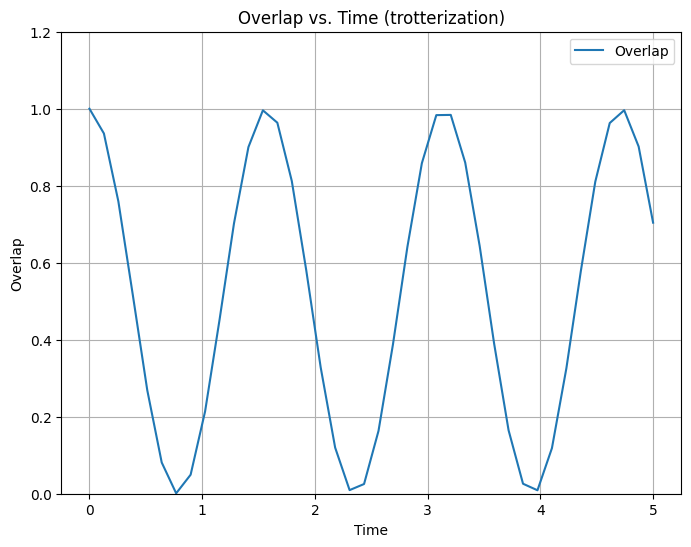

Final overlap: 0.7040410309066967


In [24]:


# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(times, overlaps, label="Overlap")
plt.xlabel("Time")
plt.ylabel("Overlap")
plt.ylim([0, 1.2])
plt.title("Overlap vs. Time (trotterization)")
plt.grid()
plt.legend()
plt.show()

print("Final overlap:", overlaps[-1])



### Exact Evolution

In [25]:

overlaps = []
overlaps1 = [] #for symmetric state
sum_overlaps = []
correlations_exact = []

# Compute the overlap with initial state
for t in times:
    result = exact_evo(t)  
    #result = result.numpy()  # Convert to NumPy array if required
    
    overlap = np.vdot(initial_state, result) 
    overlap = np.abs(overlap)**2
    overlaps.append(overlap)

    # overlap1 = np.vdot(symmetric_state, result) 
    # overlap1 = np.abs(overlap1)**2
    # overlaps1.append(overlap1)

    # sum_overlap = overlap + overlap1
    # sum_overlaps.append(sum_overlap)

    correlation_exact = correlation_function(0, 1, result)
    correlations_exact.append(correlation_exact)


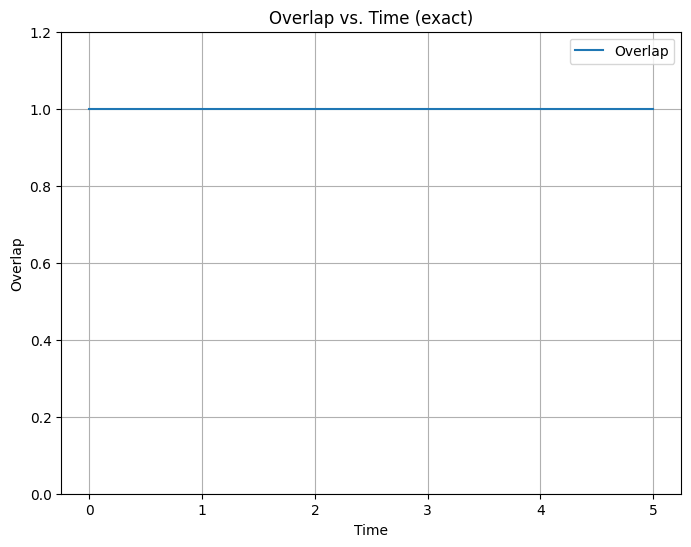

In [26]:

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(times, overlaps, label="Overlap")
plt.xlabel("Time")
plt.ylabel("Overlap")
plt.ylim([0, 1.2])
plt.title("Overlap vs. Time (exact)")
plt.grid()
plt.legend()
plt.show()

# # Plot the results
# plt.figure(figsize=(8, 6))
# plt.plot(times, overlaps1, label="Overlap")
# plt.xlabel("Time")
# plt.ylabel("Overlap")
# plt.ylim([0, 1.2])
# plt.title("Overlap vs. Time (exact)")
# plt.grid()
# plt.legend()
# plt.show()

# # Plot the results
# plt.figure(figsize=(8, 6))
# plt.plot(times, sum_overlaps, label="Overlap")
# plt.xlabel("Time")
# plt.ylabel("Overlap")
# plt.ylim([0, 1.2])
# plt.title("Overlap vs. Time (exact)")
# plt.grid()
# plt.legend()
# plt.show()

### Error

In [27]:
probabilities = []

# compute overlap between exact and paper evolution
for t in times:
    evolved_state_exact = exact_evo2(t)
    evolved_state_trotter = paper_evo(t, n_trotter_steps)  # Execute the circuit
    # evolved_state_trotter = evolved_state_trotter.numpy()  # uncomment when using pennylane_evo
    
    overlap = np.vdot(evolved_state_exact, evolved_state_trotter)
    probability = np.abs(overlap)**2
    probabilities.append(probability)

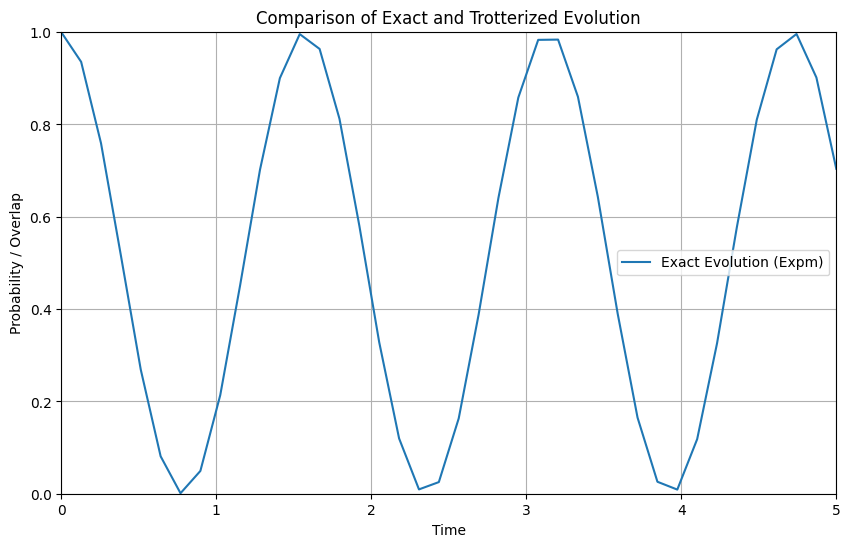

In [28]:
# Plot both results
plt.figure(figsize=(10, 6))
plt.plot(times, probabilities, label="Exact Evolution (Expm)", markersize=3)
plt.xlabel("Time")
plt.ylabel("Probability / Overlap")
plt.xlim([0, t_max])
plt.ylim([0.0, 1.001])
plt.title("Comparison of Exact and Trotterized Evolution")
plt.grid()
plt.legend()
plt.show()

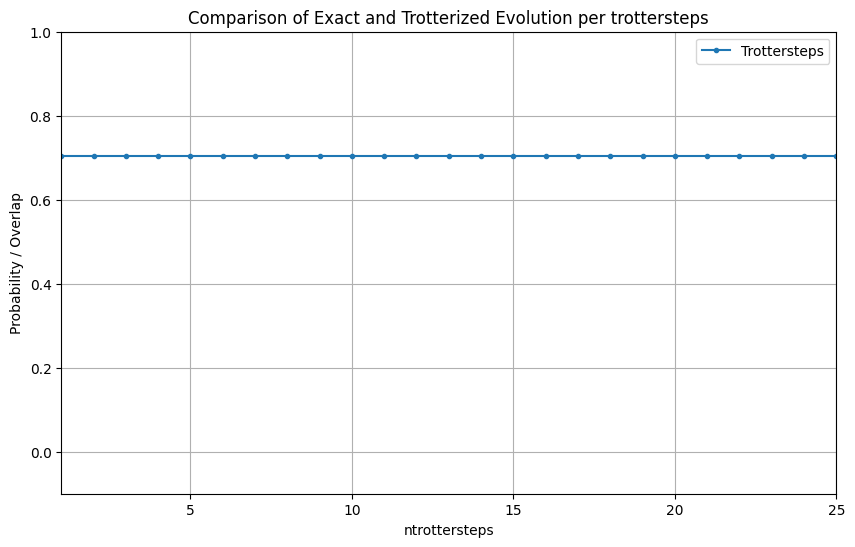

In [29]:

probabilities1 = []

min_trotter_step = 1
max_trotter_step = 25
trotter_steps = np.arange(min_trotter_step, max_trotter_step + 1)

# compute overlap between exact and paper evolution
for n in trotter_steps:
    evolved_state_exact = exact_evo(5)
    evolved_state_trotter = paper_evo(5, n)  # Execute the circuit
    # evolved_state_trotter = evolved_state_trotter.numpy()  # uncomment when using pennylane_evo
    
    overlap = np.vdot(evolved_state_exact, evolved_state_trotter)
    probability = np.abs(overlap)**2
    probabilities1.append(probability)

# Plot both results
plt.figure(figsize=(10, 6))
plt.plot(trotter_steps, probabilities1, label="Trottersteps", marker="o", markersize=3)
plt.xlabel("ntrottersteps")
plt.ylabel("Probability / Overlap")
plt.xlim([min_trotter_step, max_trotter_step])
plt.ylim([-0.1, 1.001])
plt.title("Comparison of Exact and Trotterized Evolution per trottersteps")
plt.grid()
plt.legend()
plt.show()


/Users/massimodicosimo/miniconda3/envs/qctrieste24/lib/python3.10/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/massimodicosimo/miniconda3/envs/qctrieste24/lib/python3.10/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/massimodicosimo/miniconda3/envs/qctrieste24/lib/python3.10/site-packages/matplotlib/collections.py:197: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


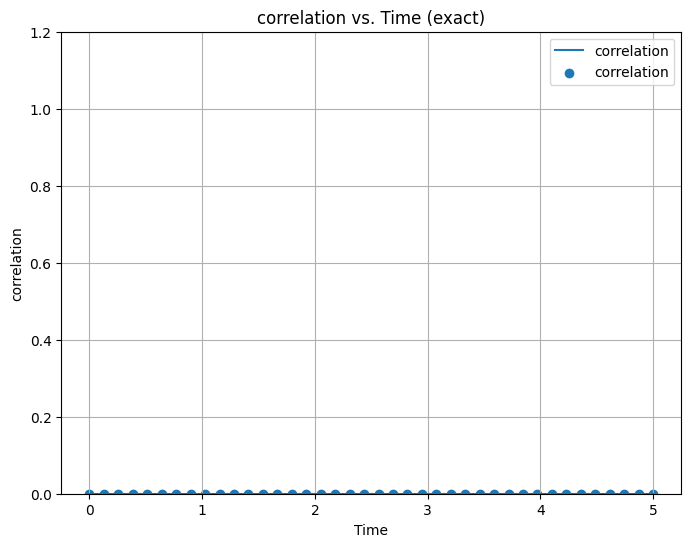

In [30]:
# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(times, correlations_exact, label="correlation")
plt.scatter(times, correlations_trotter, label="correlation")
plt.xlabel("Time")
plt.ylabel("correlation")
plt.ylim([0, 1.2])
plt.title("correlation vs. Time (exact)")
plt.grid()
plt.legend()
plt.show()

In [31]:

#checks for every inital state which one evolves
dim = 2**n_qubits
def get_initial_state(v):
    initial_state = np.zeros(dim, dtype=complex)
    initial_state[v] = 1
    return initial_state

print(initial_state.shape)

def exact_evo_all(t, v, H):
    initial_state=get_initial_state(v)
    U = np.identity(H.shape[0])
    U = U @ expm(-1j * H * (t)) 
    evolved_state = U @ initial_state
    overlap=np.abs(np.vdot(evolved_state, initial_state))**2
    return overlap

for v in range(0,2**n_qubits):
    print(v, exact_evo_all(5, v, H1), exact_evo_all(5, v, H2), exact_evo_all(5, v, H))
    

(256,)
0 1.0 1.0 1.0
1 1.0000000000000004 1.0 1.0000000000000018
2 1.0000000000000004 1.0 1.0000000000000018
3 0.7040410309066938 1.0 1.0
4 1.0000000000000004 1.0 1.0000000000000018
5 1.0000000000000027 0.08046423546177389 0.998934134827996
6 1.0000000000000027 1.0 1.0
7 1.0000000000000004 1.0 1.0000000000000018
8 1.0000000000000004 1.0 1.0000000000000018
9 1.0000000000000027 1.0 1.0
10 1.0000000000000027 0.08046423546177392 0.9989341348279966
11 1.0000000000000004 1.0 1.0000000000000018
12 0.7040410309066938 1.0 1.0
13 1.0000000000000004 1.0 1.0000000000000018
14 1.0000000000000004 1.0 1.0000000000000018
15 0.9999999999999989 1.0 1.0
16 1.0000000000000004 1.0 1.0000000000000018
17 1.0 0.08046423546177389 0.998934134827996
18 1.0 1.0 1.0
19 0.7040410309066955 1.0 1.0000000000000018
20 1.0 0.4063201903522009 0.3759941940259833
21 1.0000000000000004 0.7571000338727075 0.2820987377536765
22 1.0000000000000004 0.8502111903067805 0.2937692827461976
23 1.0000000000000022 0.5771257249437938 0

### Extra

In [32]:
# dev = qml.device("default.qubit", wires=int(np.log2(H.shape[0])))
# @qml.qnode(dev)

# def pennylane_evo(t, n, v):
#     b=int(np.log2(H.shape[0]))
#     for i in range (0, b):
#         if v >= (2**(b-i-1)):
#             qml.PauliX(wires=(i))
#             v=v-2**(b-i-1)
#         # print(v)
#     qml.ApproxTimeEvolution(H_ps.hamiltonian(), t, n)
#     return qml.state()
